### Importing Necessary Libraries

In [2]:
import re
import os
import gc
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.utils.spectral_norm as SN
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset

### Gather Dataset

In [3]:
classes = {"lenses": 0, "nonlenses": 1}
reverseclasses = {0: "lenses", 1: "nonlenses"}
dataset_dir = "dataset"

imgList, classList = [], []
for clas in classes.keys():
    main_dir = os.path.join(dataset_dir, f"train_{clas}")
    listDir = os.listdir(main_dir)

    listDir = sorted(listDir, key=lambda x: int(re.search(r"(\d+).npy", x).group(1)))
    
    for idx, item in enumerate(listDir):
        img = np.load(os.path.join(main_dir, item))
        imgList.append(img)
        classList.append(classes[clas])

imgArray = np.asarray(imgList, dtype=np.float32)
classArray = np.asarray(classList, dtype=np.int8)

### GAN for Minority Class

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            SN(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True)),
            nn.LeakyReLU(0.2, inplace=True),
            SN(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            SN(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            SN(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
            SN(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=True)),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        out = self.discriminator(x)
        out = torch.flatten(out, 1)
        return out
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Tanh(),
        )

    def forward(self, x):
        out = self.generator(x)
        return out
    
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

### Dataloader, Transform

In [5]:
batchSize = 64
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = np.transpose(image, (1, 2, 0))
        image = (image*255).astype(np.uint8)

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        
        return image, label

lensData = CustomDataset(imgArray[:1730], classArray[:1730], transform=transform)
trainLoader = DataLoader(lensData, batch_size=batchSize, shuffle=True, drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
lossfn = nn.BCELoss().to(device)
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
gen_optim = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

### Training Function

In [6]:
img_save_dir = "new"
def trainModel(discriminator, generator, lossfn, gen_optim, disc_optim, batchSize, epochs, device="cpu"):
    
    iteration_count = 0
    total_iterations = len(trainLoader) * epochs
    fixed_noise = torch.randn([batchSize, 100, 1, 1], device=device)
    featureLoss = nn.MSELoss()
    
    with tqdm(total=total_iterations, desc="GAN Training Progress") as pbar:
        
        for epoch in range(epochs):
            generator.train()
            discriminator.train()
            genBatchLoss, discBatchLoss = [], []
            
            for X, _ in trainLoader:
                real_imgs = X.to(device)
                valid = torch.ones(size=(batchSize, 1), dtype=torch.float32, device=device, requires_grad=False)
                fake = torch.zeros(size=(batchSize, 1), dtype=torch.float32, device=device, requires_grad=False)

                gen_optim.zero_grad()
                z = torch.randn((batchSize, 100, 1, 1), dtype=torch.float32, device=device)
                gen_imgs = generator(z)
                real_features = discriminator(real_imgs).mean(dim=0)
                fake_features = discriminator(gen_imgs).mean(dim=0)
                feature_match = featureLoss(fake_features, real_features)
                gen_loss = lossfn(discriminator(gen_imgs), valid) + 0.1 * feature_match
                gen_loss.backward()
                gen_optim.step()
                genBatchLoss.append(gen_loss.item())

                disc_optim.zero_grad()
                real_loss = lossfn(discriminator(real_imgs), valid)
                fake_loss = lossfn(discriminator(gen_imgs.detach()), fake)
                disc_loss = (real_loss + fake_loss) / 2
                disc_loss.backward()
                disc_optim.step()
                discBatchLoss.append(disc_loss.item())

                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_gen_loss = np.mean(genBatchLoss)
                    avg_dis_loss = np.mean(discBatchLoss)
                    pbar.set_postfix_str(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_dis_loss:.4f}")
                pbar.update(1)
            
            if (epoch+1)%10 == 0:
                checkpoint = {
                    "gen_weights": generator.state_dict(),
                    "dis_weights": discriminator.state_dict(),
                    "gen_optim": gen_optim.state_dict(),
                    "dis_optim": disc_optim.state_dict(),
                }
                torch.save(checkpoint, "task_2_gan_weights.pth")

                with torch.no_grad():
                    generator.eval()
                    fake = generator(fixed_noise).detach()
                    save_image(fake, os.path.join(img_save_dir, f"epoch_{epoch+1}.png"), normalize=True)
        
    return generator, discriminator

### Training the GAN

In [59]:
generator, discriminator = trainModel(discriminator, generator, lossfn, gen_optim, disc_optim, batchSize, epochs=500, device=device)

GAN Training Progress:   0%|          | 0/13500 [00:00<?, ?it/s]

GAN Training Progress: 100%|██████████| 13500/13500 [17:38<00:00, 12.76it/s, Generator Loss: 3.0168, Discriminator Loss: 0.0751]


### Generating new images

In [7]:
def gan_generation(generator, num_images, device, batch_size=32):
    generated_images, generated_labels = [], []

    generator = generator.to(device)
    generator.eval()

    num_complete_batches = num_images // batch_size
    remainder = num_images % batch_size

    with torch.no_grad():
        for _ in range(num_complete_batches):
            z = torch.randn((batch_size, 100, 1, 1), device=device)
            batch = generator(z).cpu().numpy()
            generated_images.append(batch)
            generated_labels.append(np.zeros(batch.shape[0], dtype=np.int8))

            del z, batch
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

            if remainder > 0:
                z = torch.randn((remainder, 100, 1, 1), device=device)
                batch = generator(z).cpu().numpy()
                generated_images.append(batch)
                generated_labels.append(np.zeros(batch.shape[0], dtype=np.int8))

                del z, batch
    
    img_array = np.concatenate(generated_images, axis=0)
    label_array = np.concatenate(generated_labels, axis=0)
    return img_array[:num_images], label_array[:num_images]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    samples_needed = len(imgArray) - 2 * 1730
    checkpoint_dir = "task_2_gan_weights.pth"
    checkpoint = torch.load(checkpoint_dir, map_location="cpu", weights_only=True)
    generator.load_state_dict(checkpoint["gen_weights"])
    del checkpoint
    gc.collect()

    new_images, new_labels = gan_generation(generator, samples_needed, device, 64)

    final_images = np.concatenate([imgArray, new_images], axis=0)
    final_labels = np.concatenate([classArray, new_labels], axis=0)
    del imgArray, classArray, new_images, new_labels
    gc.collect()

    indices = np.arange(len(final_images))
    train_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=final_labels)

    trainDataset = TensorDataset(
        torch.tensor(final_images[train_idx], dtype=torch.float32),
        torch.tensor(final_labels[train_idx], dtype=torch.int64)    
    )
    valDataset = TensorDataset(
        torch.tensor(final_images[test_idx], dtype=torch.float32),
        torch.tensor(final_labels[test_idx], dtype=torch.int64)
    )

    batchSize = 32
    trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    valLoader = DataLoader(valDataset, batch_size=batchSize, num_workers=2, pin_memory=True, persistent_workers=True)

except Exception as e:
    print(f"Error encountered: {str(e)}")

finally:
    if 'generator' in locals():
        del generator
    if 'final_images' in locals():
        del final_images
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()

### Resnet-18 for Classification

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model.fc = nn.Linear(model.fc.in_features, out_features=1, bias=True)
model.to(device)

lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Training function

In [10]:
def trainModel(model, lossfn, optimizer, iteration):
    epochs = iteration

    trainLoss = []
    iteration_count = 0
    total_iterations = len(trainLoader) * epochs

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:

        for _ in range(epochs):
            model.train()
            batchLoss = []

            for X, y in trainLoader:
                X, y = X.to(device), y.to(device)
                yHat = model(X)
                loss = lossfn(yHat.squeeze(), y.float())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batchLoss.append(loss.item())
                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss = np.mean(batchLoss)
                    trainLoss.append(avg_train_loss)
                    pbar.set_postfix_str(f"Loss: {avg_train_loss:.4f}")
                pbar.update(1)

    checkpoint = {
        "weights": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "task_2_weights.pth")

    return trainLoss, model

### Training Resnet-18

In [11]:
trainLoss, model = trainModel(model, lossfn, optimizer, iteration=30)

Training Progress: 100%|██████████| 48390/48390 [10:36<00:00, 76.06it/s, Loss: 0.0020]


### Validating the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037795894..0.90588325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037795894..0.90588325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024531243..0.9797913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024531243..0.9797913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014029037..0.9491854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014029037..0.9491854].


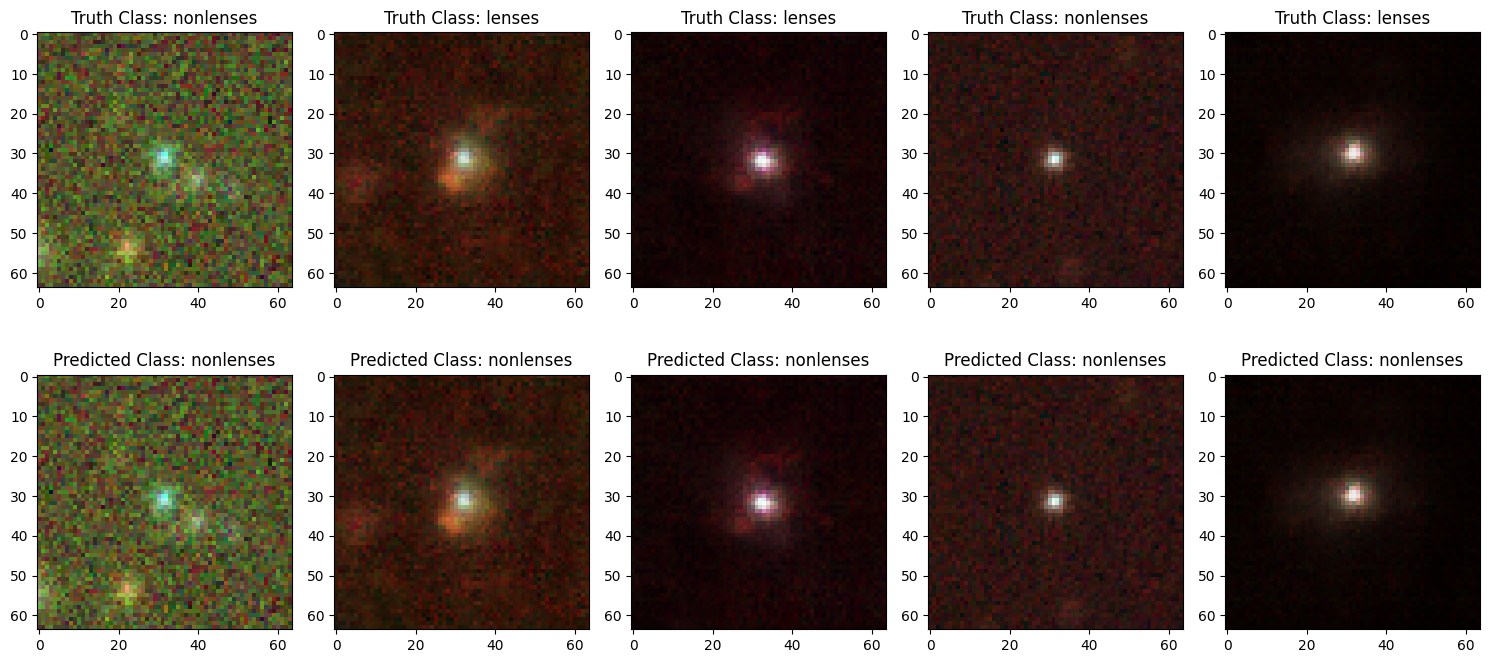

In [15]:
checkpoint_dir_model = "task_2_weights.pth"
checkpoint_model = torch.load(checkpoint_dir_model, weights_only=True)
model.load_state_dict(checkpoint_model["weights"])
model.to(device)
model.eval() 

Xtest, ytest = next(iter(valLoader))
yHattest = model(Xtest.to(device))

_, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i in range(5):
    ax[0, i].imshow(Xtest[i].cpu().detach().numpy().transpose((1, 2, 0)))
    ax[0, i].set_title(f"Truth Class: {reverseclasses[ytest[i].item()]}")

    ax[1, i].imshow(Xtest[i].cpu().detach().numpy().transpose((1, 2, 0)))
    ax[1, i].set_title(f"Predicted Class: {reverseclasses[round(torch.sigmoid(yHattest)[0].item())]}")

plt.tight_layout()
plt.show()